In [2]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator
from qvarnet.models.mlp import MLP
from qvarnet.samplersv2 import MetropolisHastingsSampler
from qvarnet.utils.callback import EarlyStoppingCallback


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import time
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def training(
    EPOCHS             = 10,
    N_SAMPLES          = 100_000,
    L_BOX              = 20.0,
    STEP_SIZE          = 0.1,
    BURN_IN            = 500,
    LEARNING_RATE      = 1e-3,
    MLP_LAYER_DIMS     = [1, 2, 1],
):
    samples_history         = []
    energy_history          = []
    energy_std_history      = []
    dict_state_history      = []
    sampling_times          = []
    energy_times            = []
    acceptance_rate_history = []

    #----------------------- DEFINE MODEL TOPOLOGY -----------------------
    model = MLP(layer_dims=MLP_LAYER_DIMS)
    model.to(device)

    model_new = MLP(layer_dims=MLP_LAYER_DIMS)
    model_new.to(device)

    # init weights
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            
            nn.init.xavier_uniform_(layer.weight, nonlinearity='tanh')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    #------------------------ DEFINE HAMILTONIAN -----------------------
    hamiltonian = HarmonicOscillator(model=model)
    hamiltonian.to(device)

    #------------------------ DEFINE SAMPLER -----------------------
    sampler = MetropolisHastingsSampler(
        model     = model,
        n_samples = N_SAMPLES,
        step_size = STEP_SIZE,
        burn_in   = BURN_IN,
        is_wf     = True,
        L_BOX     = L_BOX,
    )
    sampler.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    x0 = torch.tensor([0.0], device=device)  # Initial point for the sampler

    for _ in tqdm(range(EPOCHS)):
        optimizer.zero_grad()
        
        dict_state_history.append(model.state_dict())
        
        # Run sampler
        sampler.model = model
        start_sample_time = time.time()
        samples = sampler(x0, method="parallel", n_walkers=N_SAMPLES)
        samples.requires_grad = True
        end_sample_time = time.time()
        
        sampling_times.append(end_sample_time - start_sample_time)
        samples_history.append(samples)
        acceptance_rate_history.append(sampler.get_acceptance_rate())
        
        # Compute the mean and std of the local energy
        start_energy_time = time.time()
        hamiltonian.model = model
        local_energy = hamiltonian(samples)
        end_energy_time = time.time()
        
        energy_times.append(end_energy_time - start_energy_time)

        loss = local_energy.mean()

        energy = copy.deepcopy(loss.item())
        energy_std = local_energy.std().item() 
        energy_history.append(energy)
        energy_std_history.append(energy_std)
        
        
        # Compute gradients
        loss.squeeze().backward()
        # Update model parameters
        optimizer.step()
        
        sampler.reset_statistics()

    print("Ended training.")
    return {
        "samples_history": samples_history,
        "energy_history": energy_history,
        "dict_state_history": dict_state_history,
        "sampling_times": sampling_times,
        "energy_times": energy_times,
        "energy_std_history": energy_std_history,
        "acceptance_rate_history": acceptance_rate_history,
    }

In [4]:
results = training(
    EPOCHS             = 10,
    N_SAMPLES          = 100_000, # Play with this value
    L_BOX              = 20.0,
    STEP_SIZE          = 0.5,
    BURN_IN            = 5000, # Play with this value
    LEARNING_RATE      = 1e-3,
    MLP_LAYER_DIMS     = [1,2,1], # Play with this value
)

  0%|          | 0/10 [00:00<?, ?it/s]d:\Anaconda\envs\pytorch\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10/10 [00:36<00:00,  3.64s/it]

Ended training.


In [5]:
burn_in = range(50, 1000, 50)
results_burnin = []
for b in burn_in:
    print(f"Training with burn-in: {b}")
    result = training(
        EPOCHS             = 30,
        N_SAMPLES          = 100_000,
        L_BOX              = 20.0,
        STEP_SIZE          = 0.5,
        BURN_IN            = b,
        LEARNING_RATE      = 1e-3,
        MLP_LAYER_DIMS     = [1,2,1],
    )
    results_burnin.append(result)

Training with burn-in: 50


100%|██████████| 30/30 [00:01<00:00, 23.57it/s]


Ended training.
Training with burn-in: 100


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Ended training.
Training with burn-in: 150


100%|██████████| 30/30 [00:03<00:00,  8.42it/s]


Ended training.
Training with burn-in: 200


100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


Ended training.
Training with burn-in: 250


100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Ended training.
Training with burn-in: 300


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


Ended training.
Training with burn-in: 350


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Ended training.
Training with burn-in: 400


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Ended training.
Training with burn-in: 450


100%|██████████| 30/30 [00:10<00:00,  2.80it/s]


Ended training.
Training with burn-in: 500


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Ended training.
Training with burn-in: 550


100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Ended training.
Training with burn-in: 600


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Ended training.
Training with burn-in: 650


100%|██████████| 30/30 [00:14<00:00,  2.06it/s]


Ended training.
Training with burn-in: 700


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


Ended training.
Training with burn-in: 750


100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


Ended training.
Training with burn-in: 800


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Ended training.
Training with burn-in: 850


100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


Ended training.
Training with burn-in: 900


100%|██████████| 30/30 [00:19<00:00,  1.50it/s]


Ended training.
Training with burn-in: 950


100%|██████████| 30/30 [00:21<00:00,  1.42it/s]

Ended training.


In [6]:
def compute_mean_std(times):
    mean_time = np.mean(times)
    std_time = np.std(times)
    return mean_time, std_time

In [7]:
def plot_confidence_interval(x,data, error, **kwargs):
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(error, np.ndarray):
        error = np.array(error)
    lower_bound = data - error
    upper_bound = data + error
    kwargs_fill = copy.deepcopy(kwargs)
    if "label" in kwargs:
        kwargs_fill.pop("label")
    plt.fill_between(x, lower_bound, upper_bound, alpha=0.2, **kwargs_fill)
    plt.plot(x, data, **kwargs)

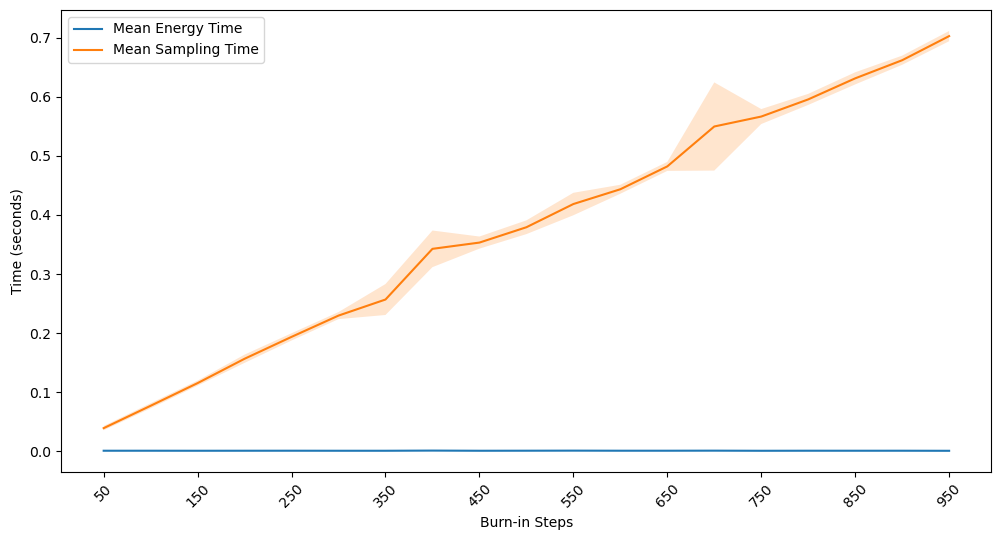

In [8]:
burnin_energy_times = []
burnin_sampling_times = []
burnin_std_energy_times = []
burnin_std_sampling_times = []

for result in results_burnin:
    energy_times = result["energy_times"]
    sampling_times = result["sampling_times"]

    mean_energy, std_energy = compute_mean_std(energy_times)
    mean_sampling, std_sampling = compute_mean_std(sampling_times)

    burnin_energy_times.append(mean_energy)
    burnin_std_energy_times.append(std_energy)
    burnin_sampling_times.append(mean_sampling)
    burnin_std_sampling_times.append(std_sampling)

plt.figure(figsize=(12, 6))
plot_confidence_interval(burn_in, burnin_energy_times, burnin_std_energy_times, label='Mean Energy Time')
plot_confidence_interval(burn_in, burnin_sampling_times, burnin_std_sampling_times, label='Mean Sampling Time')
plt.xlabel('Burn-in Steps')
plt.ylabel('Time (seconds)')
plt.xticks(burn_in[::2], rotation=45)
plt.legend();

In [9]:
results_2 = training(
    EPOCHS             = 1,
    N_SAMPLES          = 100_000, # Play with this value
    L_BOX              = 20.0,
    STEP_SIZE          = 0.5,
    BURN_IN            = 5000, # Play with this value
    LEARNING_RATE      = 1e-3,
    MLP_LAYER_DIMS     = [1,2,1], # Play with this value
)

100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

Ended training.


In [32]:
burn_in = range(50, 1050, 50)
results_burnin_2 = []
for b in burn_in:
    print(f"Training with burn-in: {b}")
    result = training(
        EPOCHS             = 1,
        N_SAMPLES          = 100_000,
        L_BOX              = 20.0,
        STEP_SIZE          = 0.5,
        BURN_IN            = b,
        LEARNING_RATE      = 1e-3,
        MLP_LAYER_DIMS     = [1,2,1],
    )
    results_burnin_2.append(result)
print(len(results_burnin_2))

Training with burn-in: 50


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Ended training.
Training with burn-in: 100


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Ended training.
Training with burn-in: 150


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Ended training.
Training with burn-in: 200


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


Ended training.
Training with burn-in: 250


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Ended training.
Training with burn-in: 300


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Ended training.
Training with burn-in: 350


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Ended training.
Training with burn-in: 400


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Ended training.
Training with burn-in: 450


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Ended training.
Training with burn-in: 500


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Ended training.
Training with burn-in: 550


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Ended training.
Training with burn-in: 600


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Ended training.
Training with burn-in: 650


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Ended training.
Training with burn-in: 700


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Ended training.
Training with burn-in: 750


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Ended training.
Training with burn-in: 800


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Ended training.
Training with burn-in: 850


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Ended training.
Training with burn-in: 900


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Ended training.
Training with burn-in: 950


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Ended training.
Training with burn-in: 1000


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Ended training.
20


20


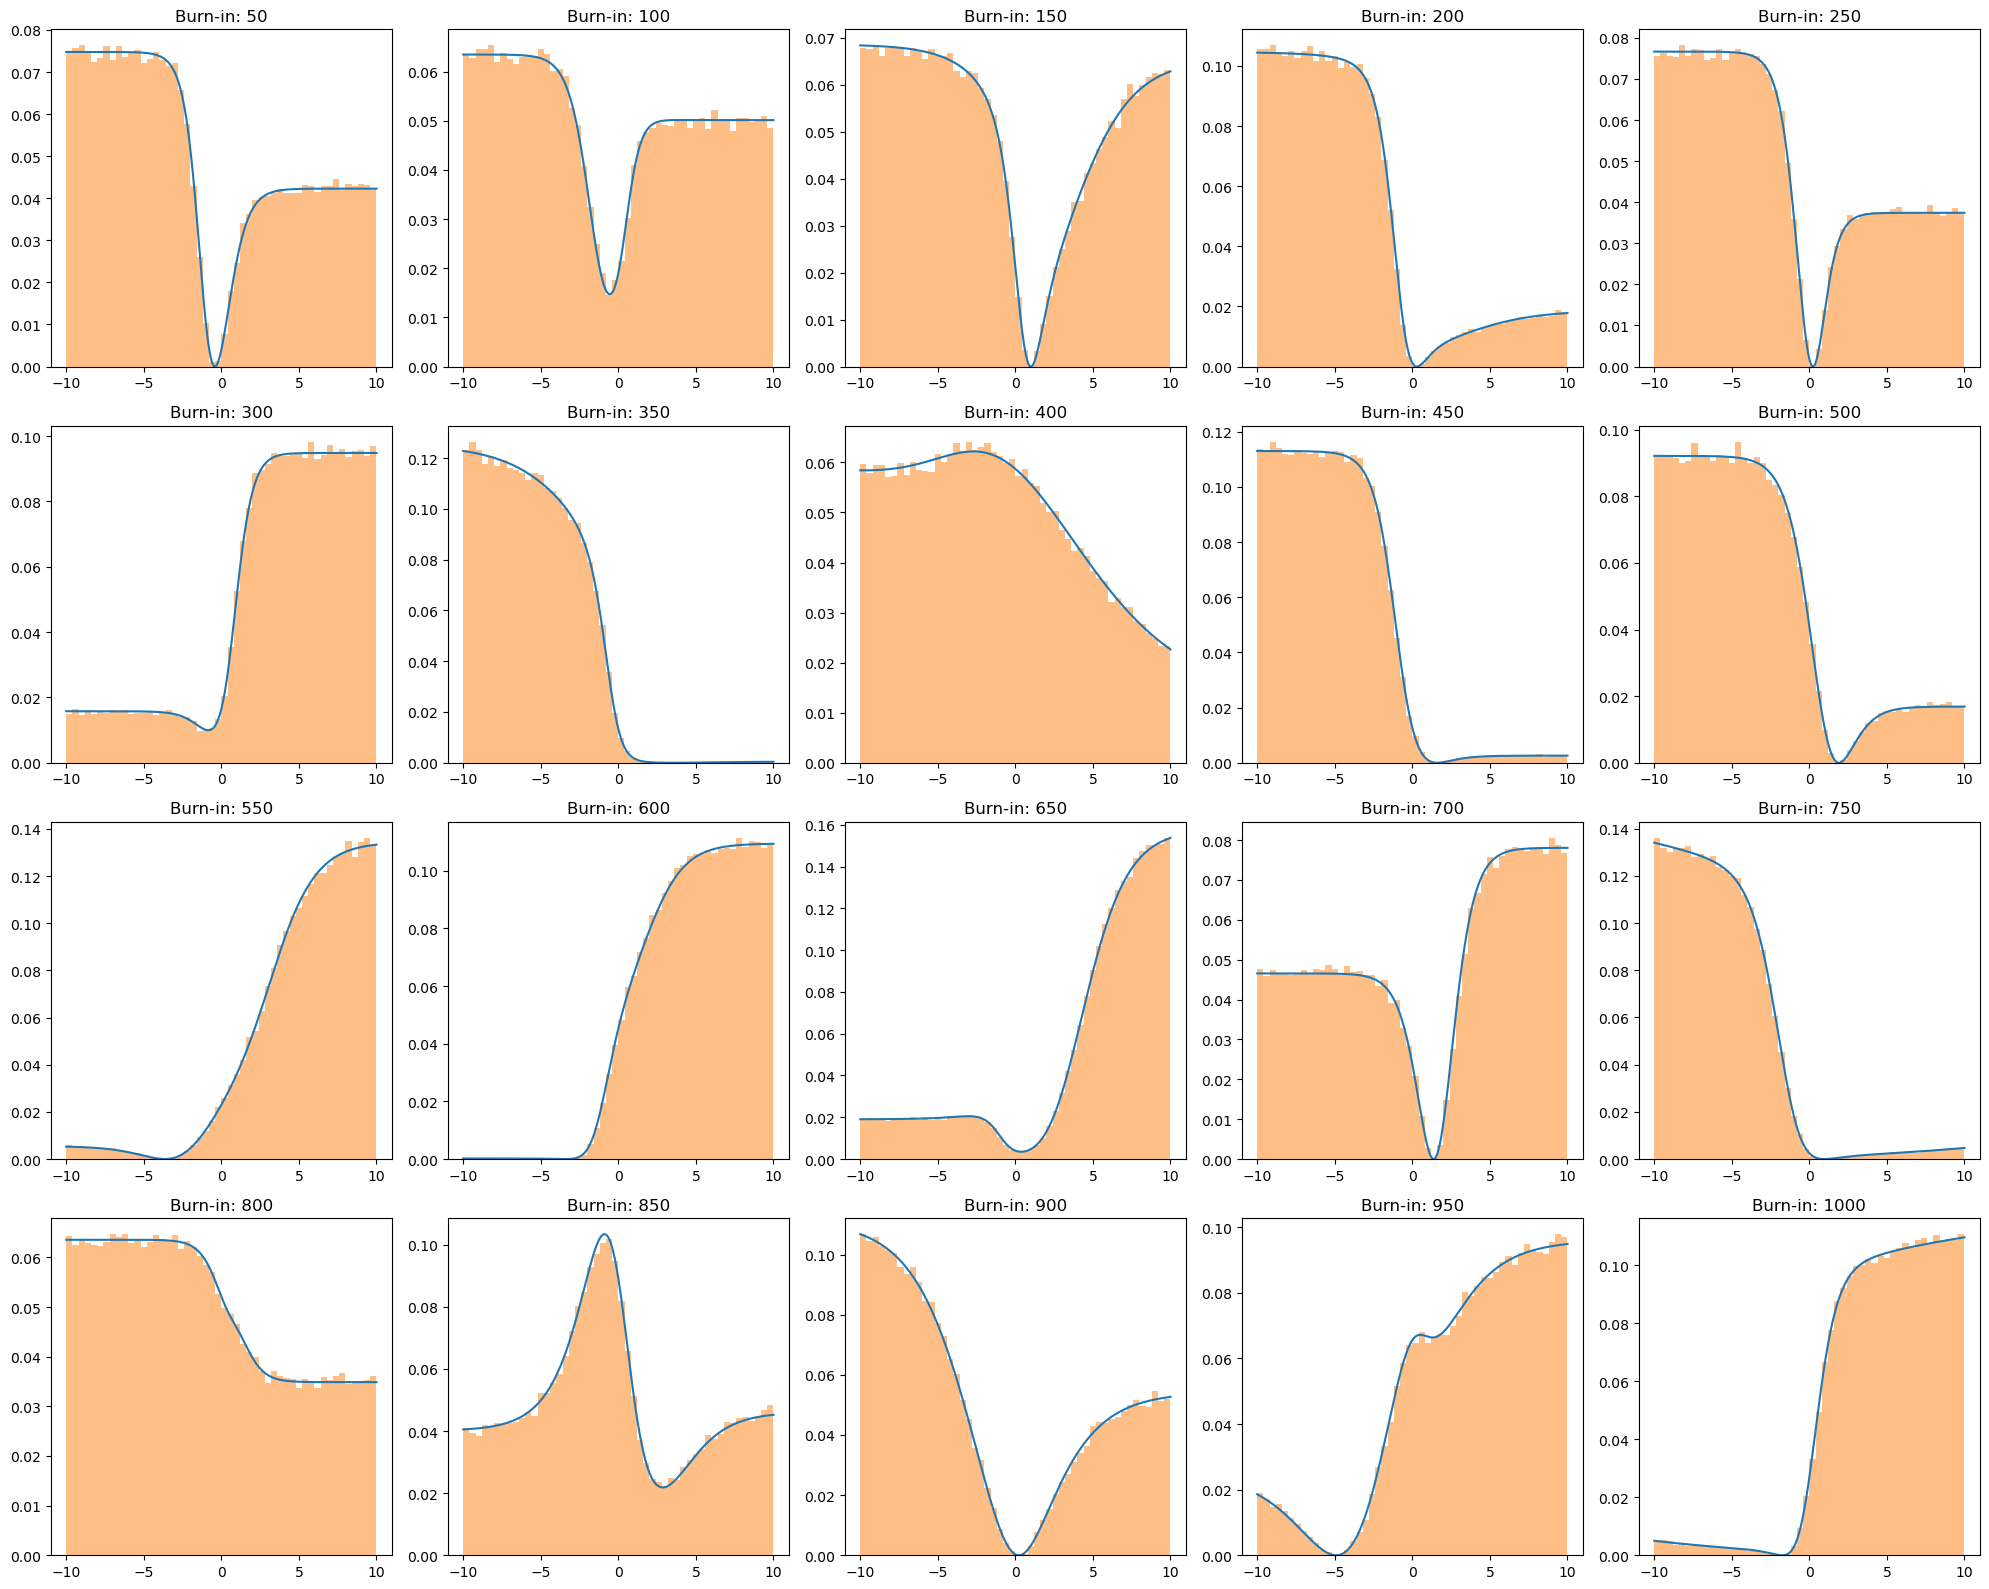

In [37]:
x_linspace = torch.linspace(-10, 10, 1000, device=device).reshape(-1, 1)

print(len(results_burnin_2))

# generate a big pic of 4x5

plt.figure(figsize=(20, 16))
# Plot the results

for i in range(len(results_burnin_2)):
    plt.subplot(4, 5, i + 1)
    plt.title(f"Burn-in: {burn_in[i]}")
    result = results_burnin_2[i]
    samples = result["samples_history"]
    
    model = MLP(layer_dims=[1, 2, 1])
    model.load_state_dict(result["dict_state_history"][0])
    model.to(device)
    y= model(x_linspace).detach().cpu().numpy()
    
    normalization_constant = np.sqrt(np.sum(y**2) * (x_linspace[1] - x_linspace[0]).item())
    y /= normalization_constant
    
    plt.plot(x_linspace.cpu().numpy(), y**2, label=f"Sample {i+1}")
    samples = samples[0].detach().cpu().numpy()
    plt.hist(samples, bins=50, density=True, alpha=0.5, label=f"Histogram {i+1}")
plt.tight_layout()

plt.show()

In [77]:
results_n_samples = []
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
n_samples = range(10_000, 2_600_000, 50_000)

for n in n_samples:
    print(f"Training with n_samples: {n}")
    result = training(
        EPOCHS             = 10,
        N_SAMPLES          = n,
        L_BOX              = 20.0,
        STEP_SIZE          = 0.5,
        BURN_IN            = 100,
        LEARNING_RATE      = 1e-3,
        MLP_LAYER_DIMS     = [1,2,1],
    )
    results_n_samples.append(result)
print(len(results_n_samples))

Training with n_samples: 10000


100%|██████████| 10/10 [00:00<00:00, 13.18it/s]


Ended training.
Training with n_samples: 60000


100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


Ended training.
Training with n_samples: 110000


100%|██████████| 10/10 [00:00<00:00, 11.90it/s]


Ended training.
Training with n_samples: 160000


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Ended training.
Training with n_samples: 210000


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Ended training.
Training with n_samples: 260000


100%|██████████| 10/10 [00:00<00:00, 12.78it/s]


Ended training.
Training with n_samples: 310000


100%|██████████| 10/10 [00:00<00:00, 13.37it/s]


Ended training.
Training with n_samples: 360000


100%|██████████| 10/10 [00:00<00:00, 13.08it/s]


Ended training.
Training with n_samples: 410000


100%|██████████| 10/10 [00:00<00:00, 12.77it/s]


Ended training.
Training with n_samples: 460000


100%|██████████| 10/10 [00:00<00:00, 12.42it/s]


Ended training.
Training with n_samples: 510000


100%|██████████| 10/10 [00:00<00:00, 11.86it/s]


Ended training.
Training with n_samples: 560000


100%|██████████| 10/10 [00:00<00:00, 11.25it/s]


Ended training.
Training with n_samples: 610000


100%|██████████| 10/10 [00:00<00:00, 10.68it/s]


Ended training.
Training with n_samples: 660000


100%|██████████| 10/10 [00:00<00:00, 10.24it/s]


Ended training.
Training with n_samples: 710000


100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


Ended training.
Training with n_samples: 760000


100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Ended training.
Training with n_samples: 810000


100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


Ended training.
Training with n_samples: 860000


100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Ended training.
Training with n_samples: 910000


100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Ended training.
Training with n_samples: 960000


100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


Ended training.
Training with n_samples: 1010000


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


Ended training.
Training with n_samples: 1060000


100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


Ended training.
Training with n_samples: 1110000


100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


Ended training.
Training with n_samples: 1160000


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Ended training.
Training with n_samples: 1210000


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Ended training.
Training with n_samples: 1260000


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Ended training.
Training with n_samples: 1310000


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Ended training.
Training with n_samples: 1360000


100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Ended training.
Training with n_samples: 1410000


100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Ended training.
Training with n_samples: 1460000


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Ended training.
Training with n_samples: 1510000


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Ended training.
Training with n_samples: 1560000


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Ended training.
Training with n_samples: 1610000


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Ended training.
Training with n_samples: 1660000


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Ended training.
Training with n_samples: 1710000


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Ended training.
Training with n_samples: 1760000


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Ended training.
Training with n_samples: 1810000


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Ended training.
Training with n_samples: 1860000


100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


Ended training.
Training with n_samples: 1910000


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Ended training.
Training with n_samples: 1960000


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Ended training.
Training with n_samples: 2010000


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Ended training.
Training with n_samples: 2060000


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Ended training.
Training with n_samples: 2110000


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Ended training.
Training with n_samples: 2160000


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Ended training.
Training with n_samples: 2210000


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Ended training.
Training with n_samples: 2260000


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Ended training.
Training with n_samples: 2310000


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Ended training.
Training with n_samples: 2360000


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Ended training.
Training with n_samples: 2410000


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Ended training.
Training with n_samples: 2460000


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Ended training.
Training with n_samples: 2510000


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Ended training.
Training with n_samples: 2560000


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]

Ended training.
52


In [78]:
# if there is more than 1 epoch, don't plot the results
if len(results_n_samples[0]["energy_times"]) < 1:
    plt.figure(figsize=(20, 16))
    # Plot the results
    for i, result in enumerate(results_n_samples):
        plt.subplot(4, 5, i + 1)
        plt.title(f"N Samples: {n_samples[i]}")
        samples = result["samples_history"]
        
        model = MLP(layer_dims=[1, 2, 1])
        model.load_state_dict(result["dict_state_history"][0])
        model.to(device)
        y= model(x_linspace).detach().cpu().numpy()
        
        normalization_constant = np.sqrt(np.sum(y**2) * (x_linspace[1] - x_linspace[0]).item())
        y /= normalization_constant
        
        plt.plot(x_linspace.cpu().numpy(), y**2, label=f"Sample {i+1}")
        samples = samples[0].detach().cpu().numpy()
        plt.hist(samples, bins=50, density=True, alpha=0.5, label=f"Histogram {i+1}")
    plt.tight_layout()

    plt.show()
else:
    print("There are more than 1 epoch, not plotting the results.")

There are more than 1 epoch, not plotting the results.


52
52


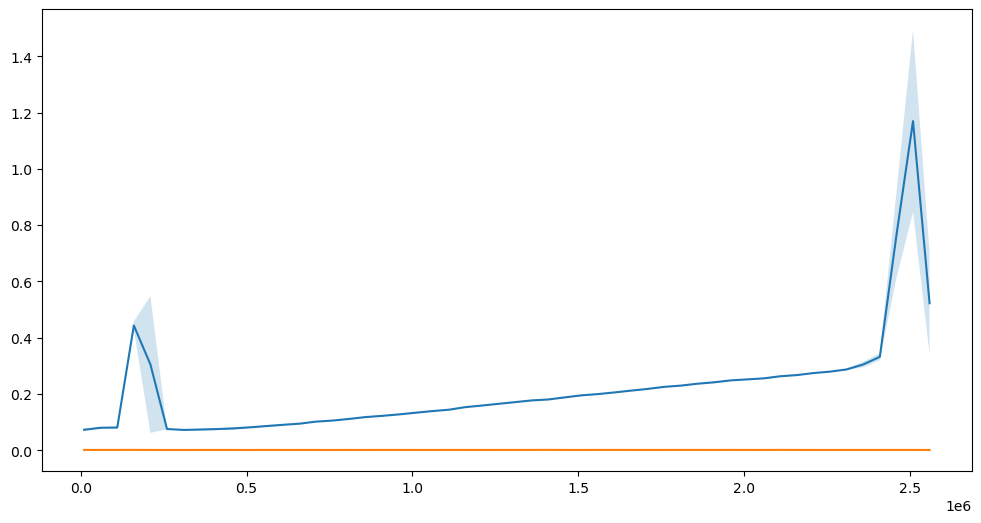

In [79]:
samples_times = []
mean_energy_times = []
samples_times_std = []
energy_times_std = []

for result in results_n_samples:
    sampling_times = result["sampling_times"]
    energy_times = result["energy_times"]
    mean_sampling, std_sampling = compute_mean_std(sampling_times)
    mean_energy, std_energy = compute_mean_std(energy_times)
    samples_times.append(mean_sampling)
    samples_times_std.append(std_sampling)
    mean_energy_times.append(mean_energy)
    energy_times_std.append(std_energy)

print(len(mean_energy_times))
print(len(energy_times_std))

plt.figure(figsize=(12, 6))
plot_confidence_interval(n_samples, samples_times, samples_times_std, label='Mean Sampling Time')
plot_confidence_interval(n_samples, mean_energy_times, energy_times_std, label='Mean Energy Time')